In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from matplotlib import pyplot as plt
# %matplotlib inline
import geopandas as gpd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Read csv Data

In [10]:
df = pd.read_csv(filepath_or_buffer = '/Electric_Vehicle_Population_Data_20240421 (1).csv',on_bad_lines='warn')

In [11]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WAUTPBFF4H,King,Seattle,WA,98126.0,2017,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,34.0,235085336,POINT (-122.374105 47.54468),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,WAUUPBFF2J,Thurston,Olympia,WA,98502.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,0,22.0,237896795,POINT (-122.943445 47.059252),PUGET SOUND ENERGY INC,5.306701e+10
2,5YJSA1E22H,Thurston,Lacey,WA,98516.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,22.0,154498865,POINT (-122.78083 47.083975),PUGET SOUND ENERGY INC,5.306701e+10
3,1C4JJXP62M,Thurston,Tenino,WA,98589.0,2021,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,0,20.0,154525493,POINT (-122.85403 46.856085),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJ3E1EC9L,Yakima,Yakima,WA,98902.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,14.0,225996361,POINT (-120.524012 46.5973939),PACIFICORP,5.307700e+10


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181458 entries, 0 to 181457
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         181458 non-null  object 
 1   County                                             181455 non-null  object 
 2   City                                               181455 non-null  object 
 3   State                                              181458 non-null  object 
 4   Postal Code                                        181455 non-null  float64
 5   Model Year                                         181458 non-null  int64  
 6   Make                                               181458 non-null  object 
 7   Model                                              181458 non-null  object 
 8   Electric Vehicle Type                              181458 non-null  object

# Cleaning Data

In [13]:
## convert Model Year and Base MSRP to numeric data type
vectorized_str = np.vectorize(str)
df['Model Year'] = pd.to_numeric(df['Model Year'],errors='coerce')
df['Base MSRP'] = pd.to_numeric(df['Base MSRP'],errors='coerce')
## Convert Legislative district to proper number
df['Legislative District'] = pd.to_numeric(df['Legislative District'],errors='coerce',downcast = 'integer')

In [ ]:
## cleaning up the column Electric Vehicle type column
conditions = [np.array(df['Electric Vehicle Type'].str.contains('Battery Electric Vehicle'),dtype=bool),
              np.array(df['Electric Vehicle Type'].str.contains('Plug-in'),dtype=bool)]
v_type = ['Battery Electric Vehicle','Plug-in']
df['Electric Vehicle Type'] = np.select(conditions,v_type,default='Other')


In [16]:
## import the csv with pricing details
price_df = pd.read_csv('/Price_list.csv')
price_df = price_df.drop(columns =['Unnamed: 0', 'Unnamed: 5']).rename(columns={'Unnamed: 6':'Base MSRP'})

## merge the price df with the existing df
df['Make '] = df['Make'].apply(lambda x: x.title() if x in['TESLA','NISSAN','CHEVROLET','FORD','KIA','BMW']  else 'Others')

df = pd.merge(left=df,right=price_df,how='left',on=['Make ', 'Model', 'Model Year', 'Electric Vehicle Type']).drop(columns=['Base MSRP_x']).rename(columns={'Base MSRP_y':'Base MSRP'})

## shape the dataframe to get in features from a geojson file for legislative districts

df_l =df.dropna(subset=['Legislative District'])
df_l.loc[:,'Legislative District'] = df_l['Legislative District'].astype(int).astype(str)

def padding(x):
  if len(str(x)) < 4:
    return '0' * (3-int(len(x)))   + str(x)
  else:
    return str(x)

df_l.loc[:,'Legislative District'] = df_l['Legislative District'].apply(padding)
df_l = df_l.rename(columns ={'Legislative District':'SLDLST'})

dfl_2 = df_l.groupby('SLDLST').agg(v_count=('VIN (1-10)','count')).reset_index()

geojson_file = '/jsonformatter (3).txt'
gdf = gpd.read_file(geojson_file)

k = pd.merge(gdf,dfl_2,on = 'SLDLST')


# Preparing Data

### Creating DataFrames to be Used in the Visualizations

In [52]:
## grouping and shaping the dataframes that will be used in the visualizations

df['Make '] = df['Make'].apply(lambda x: x.title() if x in['TESLA','NISSAN','CHEVROLET','FORD','KIA','BMW']  else 'Others') # name top players only, rest grouped as Others

model_year_counts = df[df['Model Year'].isin(range(1995,2025,1))].groupby('Model Year')['VIN (1-10)'].agg('count') # df to count vehicles by model years

model_year_counts_make = df[df['Model Year'].isin(range(2015,2026,1)) ].groupby(['Model Year','Make '])['VIN (1-10)'].agg('count').reset_index() # df that counts number of vehicles by Make and  by Model Year

model_year_counts_make['Market Share'] = model_year_counts_make['VIN (1-10)']/model_year_counts_make.groupby(['Model Year'])['VIN (1-10)'].transform(lambda x : x.sum()) * 100 # calculate market share for a Make in a Model Year

df_make = df[df.groupby(['Make'])['VIN (1-10)'].transform(lambda x: x.shape[0])>1000] # df that consists data of Make that has at least 1000 vehicles over the years

filtered_make = list(df_make['Make'].value_counts().index[:6]) # count of vehicles by Make to get the Make with most vehicles

filtered_df = df_make[df['Make'].isin(filtered_make)]

count_df = filtered_df.groupby(['Make','Model Year']).agg(value_counts = ('Model','nunique')).unstack().T.fillna(0).reset_index() #df to calculate number of unique models by Make per Model Year

df_2 =df[df['Model Year'] == 2024] #df for only 2024

df_make_2 = df_2[(df_2.groupby(['Make'])['VIN (1-10)'].transform(lambda x: x.shape[0])>100) ] # df for 2024 with Makes who at least have 100 vehicles registerd


filtered_make_2 = list(df_make['Make'].value_counts().index[:10]) # similar to filtered_make
filtered_df_2 = df_make[df['Make'].isin(filtered_make_2)] # similar to filtered_df

count_df_2 = filtered_df_2.groupby(['Make','Model Year','Electric Vehicle Type']).agg(count_of_models = ('Model','nunique'),n_v = ('VIN (1-10)', 'count')).reset_index().rename(columns={'count_of_models':'Model Count','n_v':'Number of Vehicles'})
count_df_2['Make '] = count_df_2['Make'].apply(lambda x: x.title() if x in['TESLA','NISSAN','CHEVROLET','FORD','KIA','BMW','JEEP']  else 'Others')

conditions = (count_df_2['Make '].isin(['Bmw','Kia','Jeep'])) & (count_df_2['Model Year'] > 2018)



<ipython-input-52-ec4a69cdef45>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df_make[df['Make'].isin(filtered_make)]
<ipython-input-52-ec4a69cdef45>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df_2 = df_make[df['Make'].isin(filtered_make_2)]


### Functions to call the charts

In [94]:
def chart1():
  fig,ax = plt.subplots(2,2,figsize=(20,10))

  ax[0,0].plot(model_year_counts.index,model_year_counts.values)
  ax[0,0].set_xticks(ticks =range(1995, 2026, 1), labels = range(1995, 2026, 1),rotation=90)
  ax[0,0].set_xlabel('Model Year')
  ax[0,0].set_ylabel('Number of Cars Registered')
  ax[0,0].set_title('Electric Vehicle Trend by Model Year in Washington State')

  df_make['Make'].value_counts().sort_values().plot(kind='barh',ax = ax[0,1])
  ax[0,1].set_xlabel('Number of Registered Vehicles')
  ax[0,1].set_title('Most Popular Electric Vehicles in Wahington State')

  hue_order = ['Tesla','Nissan','Chevrolet','Ford','Kia','Bmw','Others']
  sns.lineplot(data = model_year_counts_make,x='Model Year',y='Market Share',hue='Make ',ax=ax[1,0],hue_order=hue_order)
  ax[1,0].set_xticks(ticks =range(2015, 2026, 1), labels = range(2015, 2026, 1),rotation=90)
  ax[1,0].set_yticks(ticks =range(0, 100, 10), labels = range(0, 100, 10))
  ax[1,0].set_xlabel('Model Year')
  ax[1,0].set_ylabel('Market Share Percentage')
  ax[1,0].set_title('Market Share by Model Year in Washington State')
  ax[1,0].annotate("Tesla's Market Share in 2024!", xy=(2020, 80), xytext=(2020, 80),
                  fontsize=10, ha='center')

  ax[1,1].bar(count_df['Model Year'],count_df['TESLA'],label='Tesla')
  ax[1,1].bar(count_df['Model Year'],count_df['NISSAN'],bottom = count_df['TESLA'],label='Nissan')
  ax[1,1].bar(count_df['Model Year'],count_df['CHEVROLET'],bottom = count_df['NISSAN']+count_df['TESLA'],label='Chevrolet')
  ax[1,1].bar(count_df['Model Year'],count_df['FORD'],bottom = count_df['CHEVROLET']+count_df['NISSAN']+count_df['TESLA'],label='Ford')
  ax[1,1].bar(count_df['Model Year'],count_df['KIA'],bottom = count_df['FORD']+count_df['CHEVROLET']+count_df['NISSAN']+count_df['TESLA'],label='Kia')
  ax[1,1].bar(count_df['Model Year'],count_df['BMW'],bottom = count_df['KIA']+count_df['FORD']+count_df['CHEVROLET']+count_df['NISSAN']+count_df['TESLA'],label='Bmw')
  ax[1,1].tick_params(axis='x', bottom=False)
  ax[1,1].set_xticks(ticks =range(1997, 2026, 1), labels = range(1997, 2026, 1),rotation=90)
  ax[1,1].set_xlabel('Model Year')
  ax[1,1].set_ylabel('Number of Models')
  ax[1,1].set_title('Number of Models per Year')
  ax[1,1].annotate("More Models by the Years!", xy=(2009, 22.5), xytext=(2009, 22.5),
                  fontsize=10, ha='center')
  ax[1,1].legend()
  fig.suptitle('Electric Vehicle Analysis in Washington State', fontsize=16)
  fig.tight_layout()
  plt.show()

def chart2():

  fig,ax = plt.subplots(1,2,figsize=(20,8))

  df_make_2['Make'].value_counts().sort_values().plot(kind='barh',ax = ax[1])
  ax[1].set_xlabel('Number of Registered Vehicles')
  ax[1].set_title('Most Popular Electric Vehicles in Wahington State in 2024')

  df_make['Make'].value_counts().sort_values().plot(kind='barh',ax = ax[0])
  ax[0].set_xlabel('Number of Registered Vehicles')
  ax[0].set_title('Most Popular Electric Vehicles in Wahington State 1997 - 2024')
  fig.suptitle('What about 2024 Models?', fontsize = 16)
  ax[1].annotate('NO FORD!, NO NISSAN!, NO CHEVY!', xy=(1500, 10), xytext=(1500, 10),
                  fontsize=14, ha='center')
  fig.tight_layout()

def chart_3():
  fig,ax = plt.subplots(2,2,figsize=(12,8))
  hue_order = ['Tesla','Nissan','Chevrolet','Ford','Kia','Bmw']
  sns.lineplot(data = df[(df['Make '] != 'Others') &(df['Model Year'] >2015)&(df['Electric Vehicle Type']=='Battery Electric Vehicle')], x = 'Model Year', y = 'Base MSRP', hue = 'Make ',hue_order = hue_order,ax=ax[0,0])
  sns.lineplot(data = df[(df['Make '] != 'Others') &(df['Model Year'] >2015)&(df['Electric Vehicle Type']=='Plug-in')], x = 'Model Year', y = 'Base MSRP', hue = 'Make ',hue_order = hue_order,ax=ax[0,1])
  sns.lineplot(data = count_df_2[(count_df_2['Model Year']>2015) & (count_df_2['Electric Vehicle Type']=='Battery Electric Vehicle')],x='Model Year',y='Model Count', hue = 'Make ',hue_order = hue_order, ax= ax[1,0])
  sns.lineplot(data = count_df_2[(count_df_2['Model Year']>2015) & (count_df_2['Electric Vehicle Type']=='Plug-in')],x='Model Year',y='Model Count', hue = 'Make ',hue_order = hue_order, ax= ax[1,1])
  sns.move_legend(ax[0,1], "lower left",bbox_to_anchor=(1,0), ncol=1, title='Make', frameon=True)
  ax[0,0].set_yticks(ticks =range(0, 90000, 10000), labels = range(0, 90000, 10000))
  ax[0,0].set_title('Average Price of Vehicles Sold - Battery Electric Vehicle')
  ax[0,1].set_yticks(ticks =range(0, 90000, 10000), labels = range(0, 90000, 10000))
  ax[1,0].set_yticks(ticks = range(1, 7, 1), labels = range(1, 7, 1))
  ax[1,1].set_yticks(ticks = range(1, 7, 1), labels = range(1, 7, 1))
  ax[0,1].set_ylabel('Average Base MSRP - USD')
  ax[0,0].set_ylabel('Average Base MSRP - USD')
  ax[0,1].set_title('Average Price of Vehicles Sold - Plug-in')
  ax[1,0].set_title('Number of Models - Battery Electric Vehicle')
  ax[1,1].set_title('Number of Models - Plug-in')
  ax[0,0].get_legend().remove()
  ax[1,1].get_legend().remove()
  ax[1,0].get_legend().remove()
  fig.suptitle('Price and Number of Models over the Years', fontsize = 16)
  fig.tight_layout()
  plt.show()

def chart_4():
  row_order = ['BMW','KIA','JEEP']
  plot = sns.catplot(count_df_2[conditions], hue = 'Electric Vehicle Type', y = 'Number of Vehicles', col = 'Model Year', row = 'Make', kind = 'bar',row_order= row_order,aspect= 1.25,height=2.5)
  plot.fig.suptitle('BMW, KIA, JEEP Analysis by Make and Model Year', fontsize=18)
  plt.tight_layout(pad=1)
  plt.show()

def chart_5():
  ax = k.plot(column='v_count', cmap='RdYlGn', legend=True, figsize=(15,15),alpha=0.8,legend_kwds={'shrink': 0.3})

  # Define the districts you want to shade differently
  districts_to_shade = ['002','004','006','007','008','009','010','012','013','014','015','016','017','018','019','020','025','026','031','035','039']  # Replace with your district IDs

  # Plot the shaded districts with patterns
  shaded_districts = k[k['SLDLST'].isin(districts_to_shade)]
  shaded_districts.plot(ax=ax, color='none', edgecolor='black', hatch='//')  # Adjust color and hatch pattern as needed
  ax.set_title('Registered EV Count by Legislative District')
  legend_elements = [Patch(facecolor='none', edgecolor='black', hatch='//', label='Republican Legislature')]
  ax.legend(handles=legend_elements, loc='upper right')
  colorbar = ax.get_figure().get_axes()[1]
  colorbar.set_ylabel('EV Vehicle Count', fontsize=12)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  plt.show()

## Data Visualization

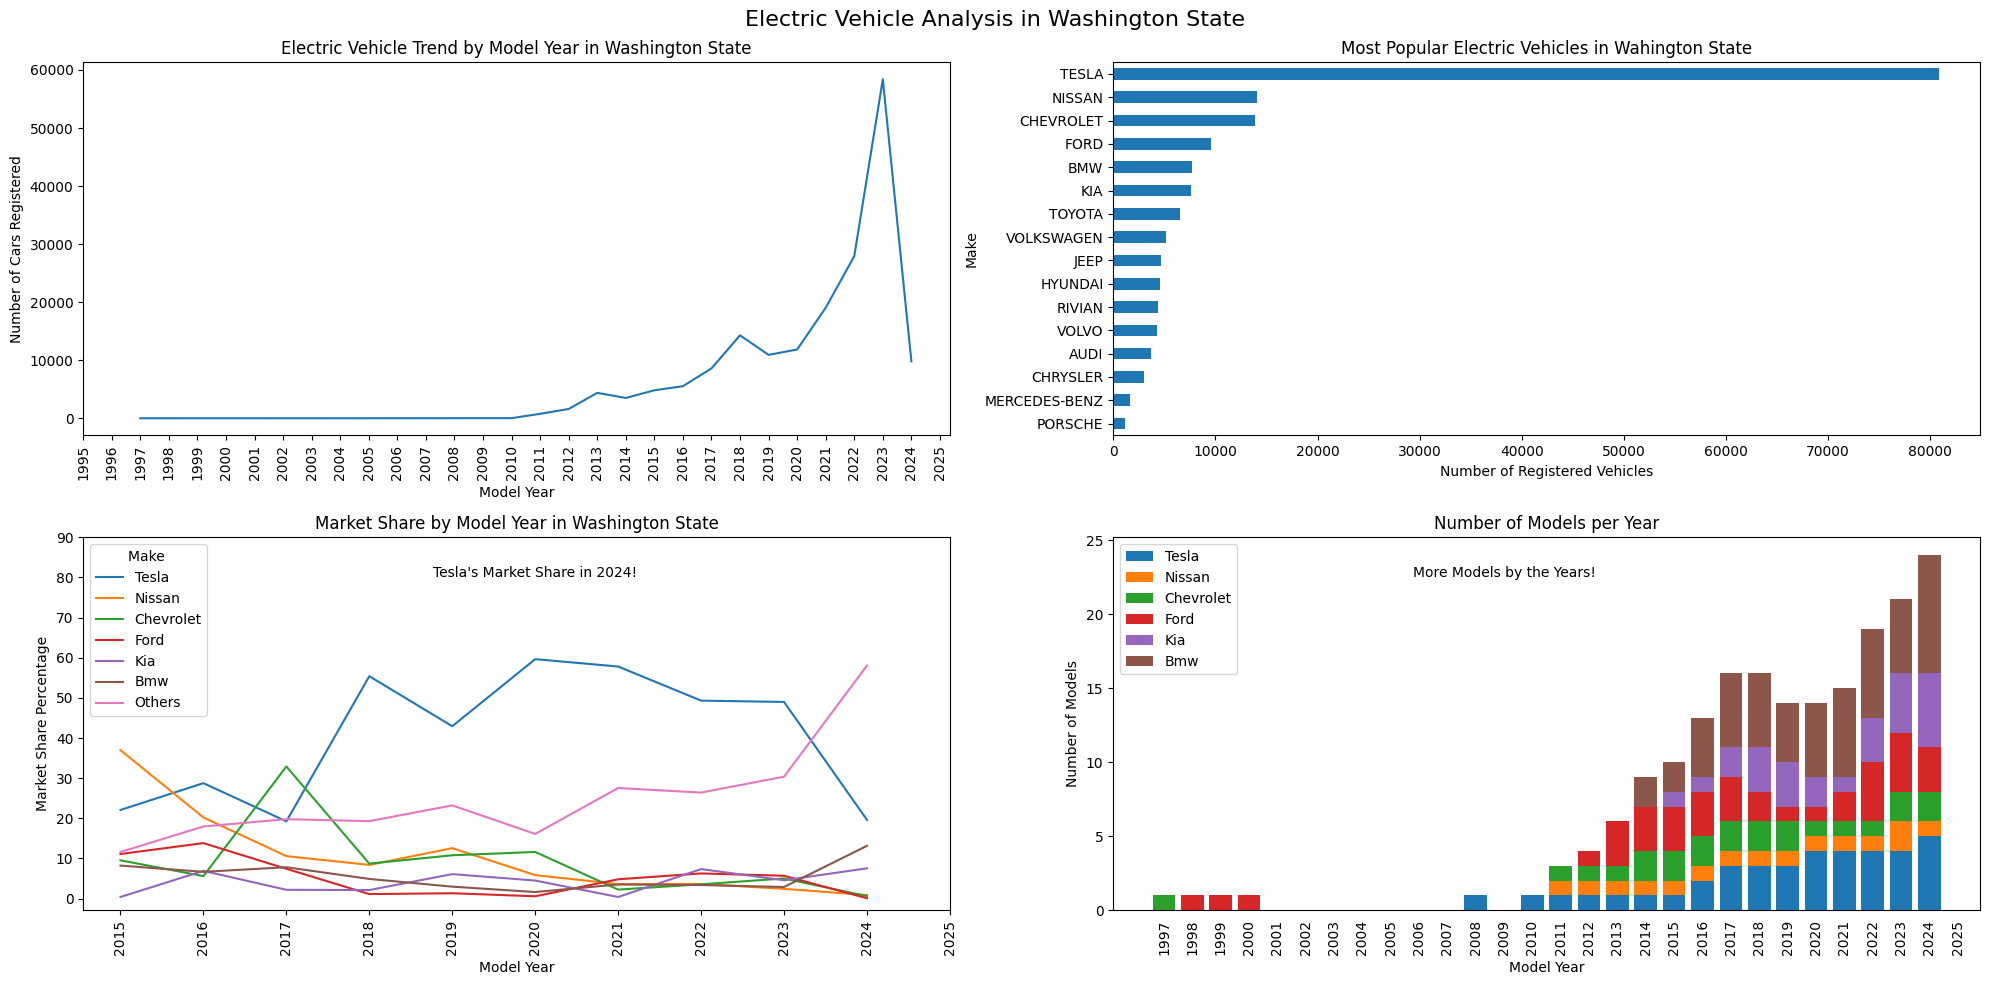

In [86]:
chart1()

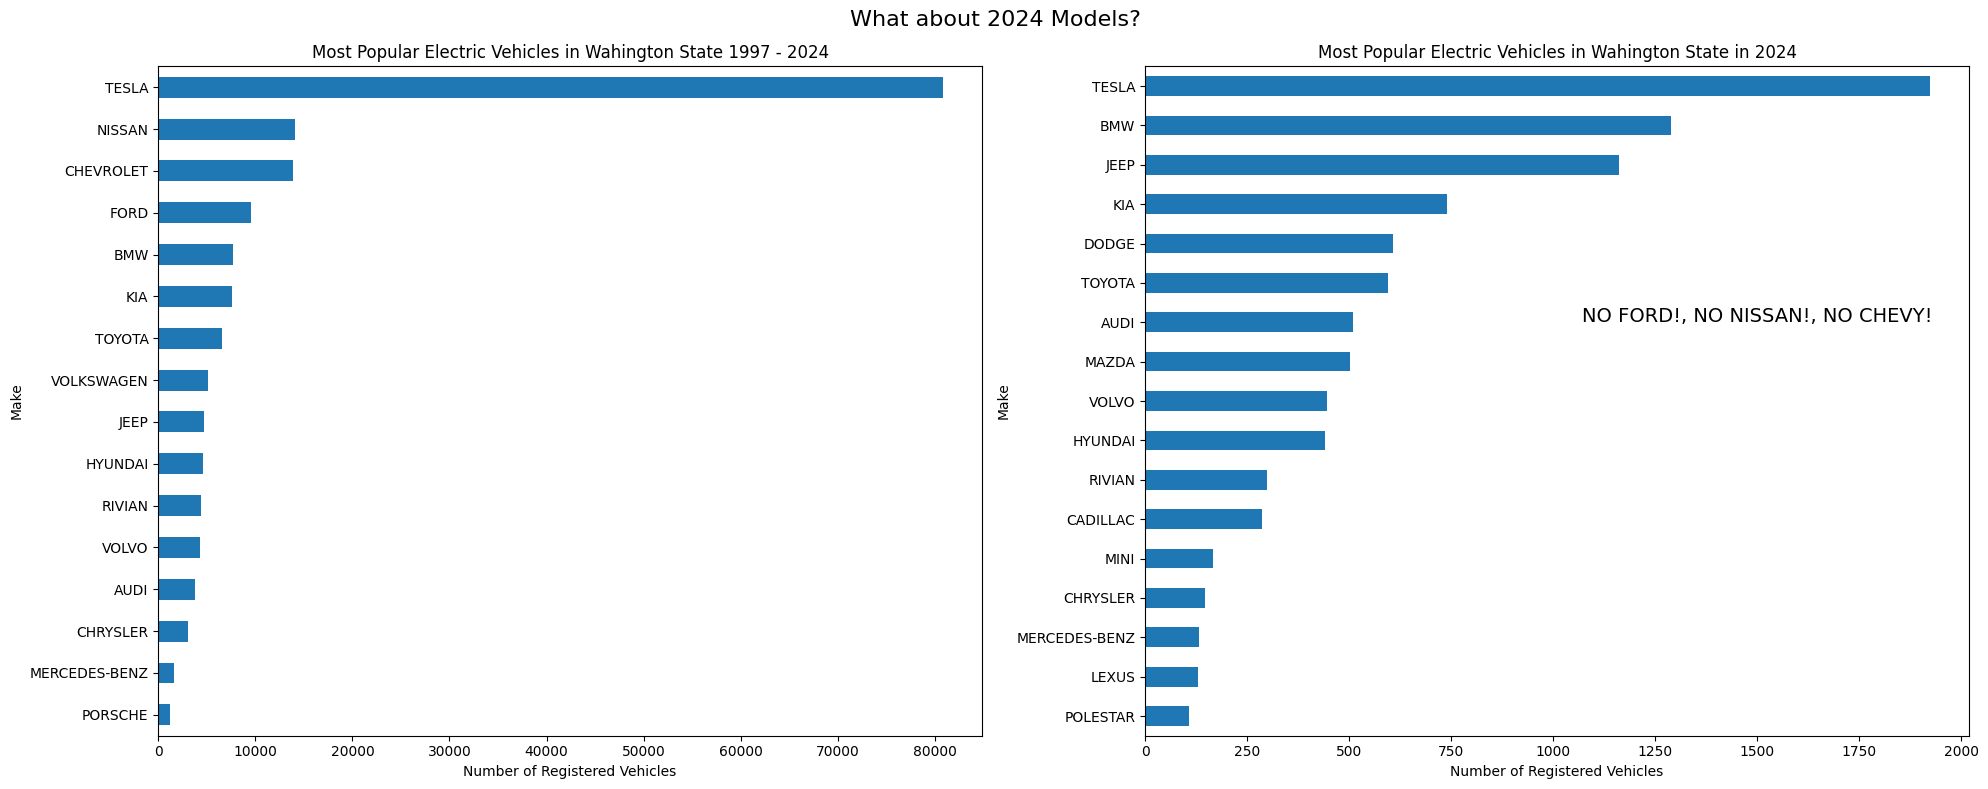

In [88]:
chart2()

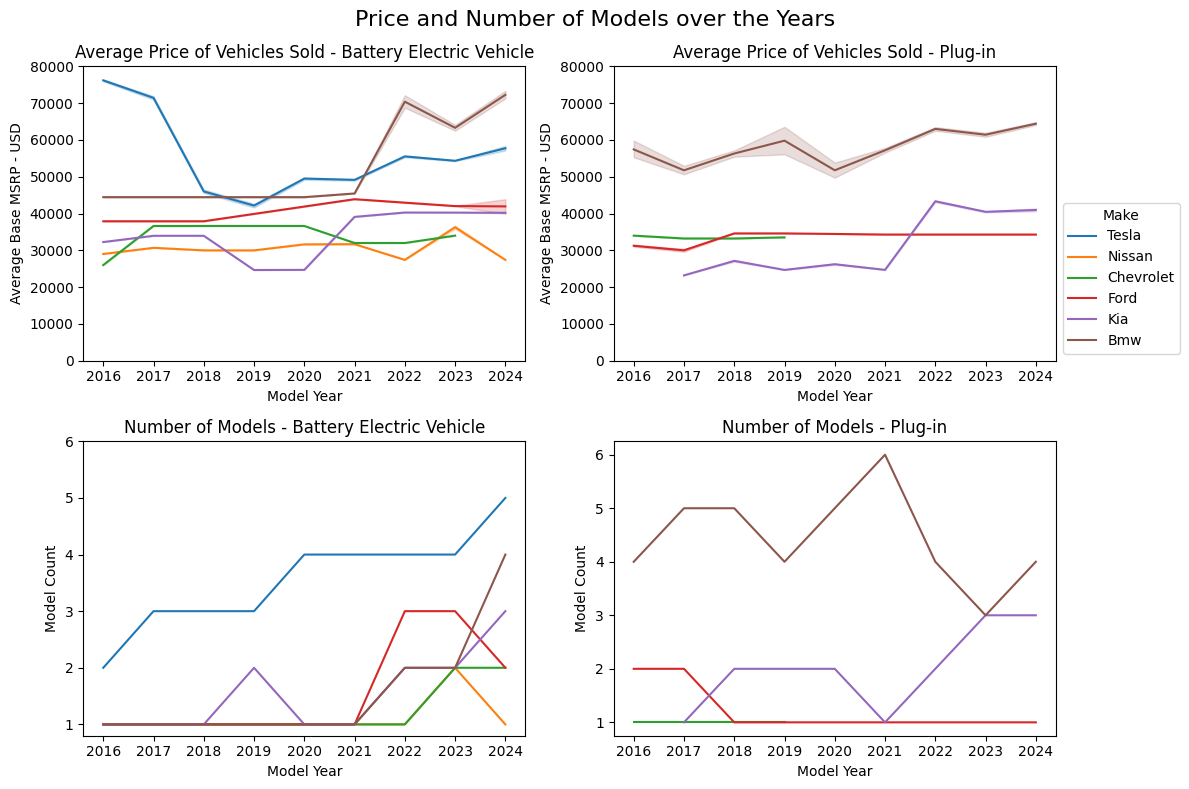

In [89]:
chart_3()

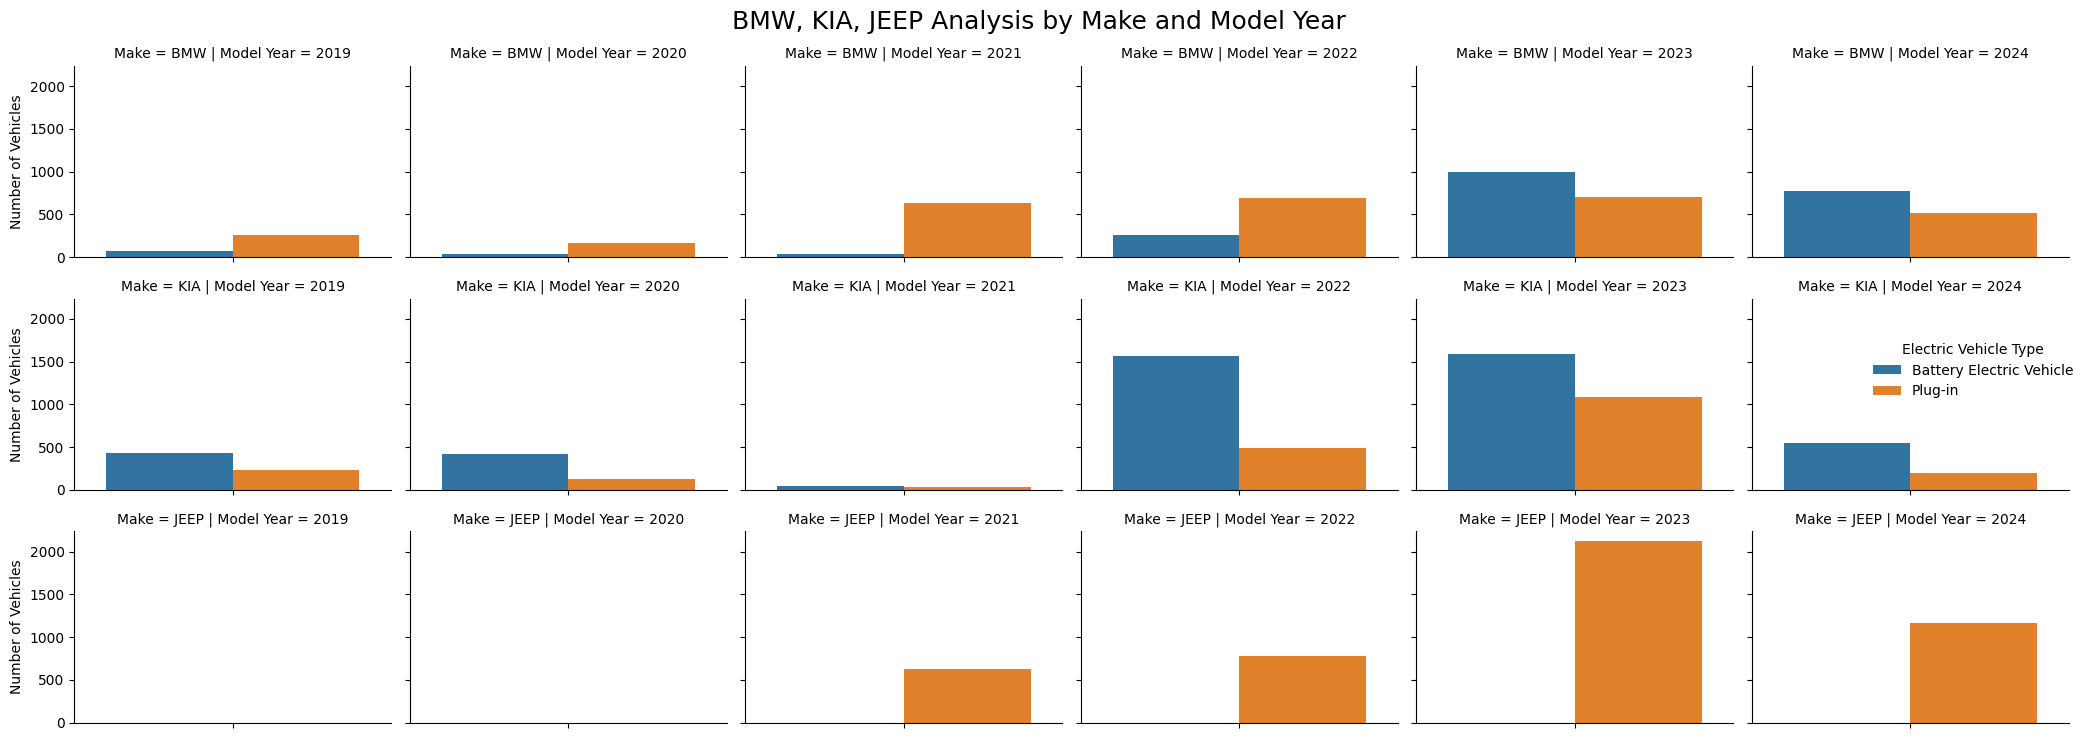

In [95]:
chart_4()

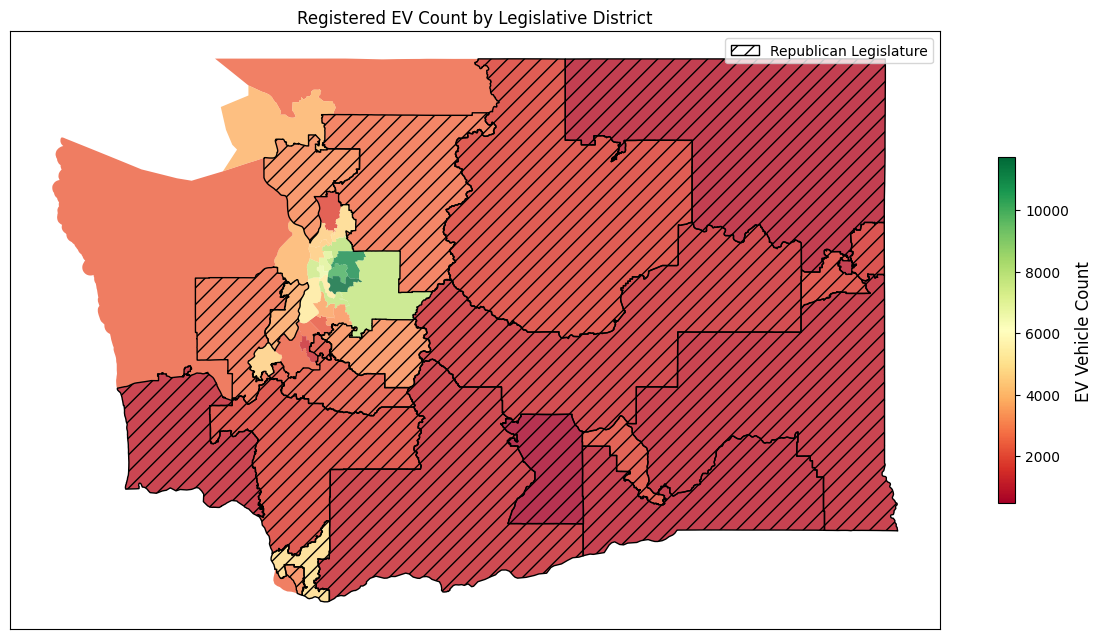

In [91]:
chart_5()